In [1]:
import numpy as np
import pandas as pd

DATA_PATH = "/Users/junwoong/Desktop/멋쟁이 사자처럼/Final_Project/1107/"
DATA_PATH_2 = "/Users/junwoong/Desktop/멋쟁이 사자처럼/Final_Project/data/"

In [2]:
train_tr = pd.read_csv(f"{DATA_PATH_2}store_train_transactions.csv") # 학습용 구매기록 데이터
train_target = pd.read_csv(f"{DATA_PATH_2}store_train.csv") # 학습용 정답 데이터
test_tr = pd.read_csv(f"{DATA_PATH_2}store_test_transactions.csv") # 테스트용 구매기록 데이터
submit = pd.read_csv(f"{DATA_PATH_2}store_submission.csv") # 제출 양식 데이터

train_tr.shape , train_target.shape , test_tr.shape , submit.shape

target = train_target["target"]
target

0        1.0
1        1.0
2        0.0
3        0.0
4        0.0
        ... 
14935    0.0
14936    0.0
14937    0.0
14938    1.0
14939    1.0
Name: target, Length: 14940, dtype: float64

In [3]:
train_ft = pd.read_csv(f"{DATA_PATH}train_scaling.csv")
test_ft = pd.read_csv(f"{DATA_PATH}test_scaling.csv")

train_ft = train_ft.drop(columns="Unnamed: 0")
test_ft = test_ft.drop(columns="Unnamed: 0")

train_ft.shape, test_ft.shape

((14940, 9259), (12225, 9259))

## 점수확인

In [7]:
SEED = 42

In [8]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(5, shuffle=True, random_state=SEED)

In [9]:
model = LGBMClassifier(random_state=SEED, verbose=-1, boost_from_average=True)
scores = cross_val_score(model, train_ft, target, cv=cv, n_jobs=-1, scoring="f1_macro")
scores.mean()

np.float64(0.7211417814135069)

In [14]:
model = LGBMClassifier(random_state=SEED, verbose=-1)
model.fit(train_ft, target)

LGBMClassifier(random_state=42, verbose=-1)

## 차원 축소

In [19]:
import matplotlib
from matplotlib import font_manager


fontpaths = ["/System/Library/Fonts/Supplemental/Andale Mono.ttf"]
font_files = font_manager.findSystemFonts(fontpaths=fontpaths)

for ff in font_files:
    font_manager.fontManager.addfont(ff)

matplotlib.rc('font', family="AppleGothic")
matplotlib.rcParams['axes.unicode_minus'] = False

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


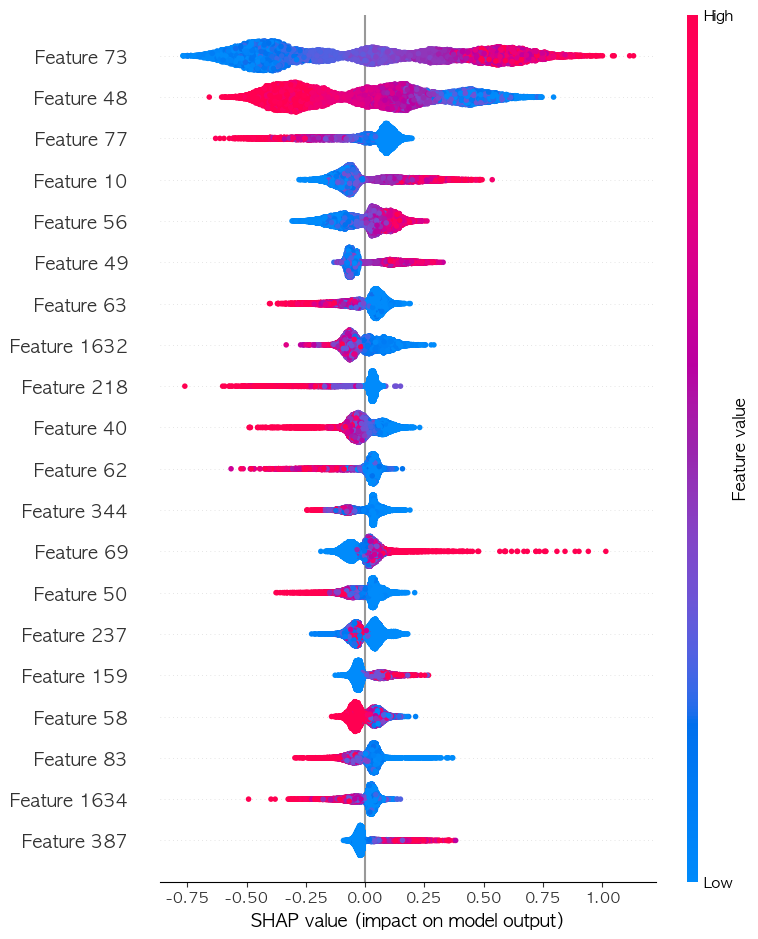

In [31]:
import shap

# TreeExplainer를 사용하여 모델 초기화
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_ft)

# 요약 플롯 생성
shap.summary_plot(shap_values, train_ft)

In [22]:
from sklearn.feature_selection import SelectKBest, VarianceThreshold

vt = VarianceThreshold(threshold=0)
train_vt = vt.fit_transform(train_ft)
test_vt = vt.transform(test_ft)

In [23]:
skb = SelectKBest(k=1800)
train_ft = skb.fit_transform(train_vt, target)
test_ft = skb.transform(test_vt)
train_ft.shape, test_ft.shape

((14940, 1800), (12225, 1800))

## 점수 확인 후 제출 파일 생성

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=SEED, verbose=-1, boost_from_average=True)
scores = cross_val_score(model, train_ft, target, cv=cv, scoring="f1_macro", n_jobs=-1)
np.mean(scores)

np.float64(0.7237532512633149)

In [27]:
model = LGBMClassifier(random_state=SEED, verbose=-1, boost_from_average=True)
model.fit(train_ft,target)

LGBMClassifier(boost_from_average=True, random_state=42, verbose=-1)

In [28]:
pred = model.predict(test_ft)
pred

array([0., 0., 0., ..., 0., 0., 0.])

In [29]:
submit["target"] = pred
submit

,ID,target
0,test_0,0.0
1,test_1,0.0
2,test_2,0.0
3,test_3,1.0
4,test_4,1.0
...,...,...
12220,test_12220,1.0
12221,test_12221,0.0
12222,test_12222,0.0
12223,test_12223,0.0


In [30]:
submit.to_csv(f"{DATA_PATH}submit_1107_2.csv",index=False)